In [1]:
%run ../_preamble.ipynb
from _work.src.data import generate_data, create_dataloader, small_dataloader
from _work.src.models import AutoEncoder
from _work.src.modules import train_model, test_model, plot_metrics, plot_parameters, plot_tensor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [2]:
# NUM_ITEMS = 8
# NUM_ATTRIBUTES = 7
# data = generate_data(NUM_ITEMS, NUM_ATTRIBUTES)
# # dataloader = create_dataloader(data, weights=[*([1] * (NUM_ITEMS - 1)), 0.1])
# dataloader = create_dataloader(data, weights=None)

# dataloader = create_dataloader(small_dataloader.dataset, weights=[*([1] * 7), 0.1])
dataloader = small_dataloader
NUM_ATTRIBUTES = dataloader.dataset.NUM_ATTRIBUTES
NUM_ITEMS = dataloader.dataset.NUM_ITEMS

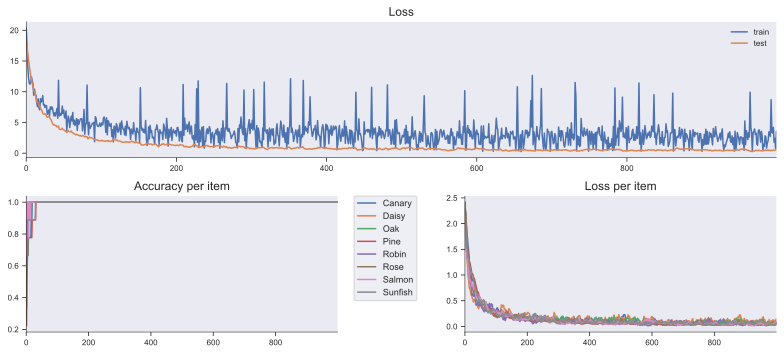

In [161]:
HIDDEN_SIZE = 64

metrics = train_model(
    model := AutoEncoder(
        sizes=[NUM_ATTRIBUTES, HIDDEN_SIZE],
        batch_norm=True,
        dropout=0.5,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1000,
    # l1_lambda=0.005,
    # noise_mean=0,
    # noise_stdev=1,
    # replay_interval=500,
    # replay_duration=500,
    # replay_strategy="conditional",
    # reset=False,
)

plot_metrics(metrics);

In [162]:
from torch.autograd.functional import jacobian

model.eval()
# def func(*args):
#     return tuple(model(x) for x in args)

def func(*args):
    return model(torch.vstack(args))

# j = jacobian(func, torch.vstack(tuple(x['y'] for x in dataloader.dataset)))
j = jacobian(func, tuple(x['y'] for x in dataloader.dataset))

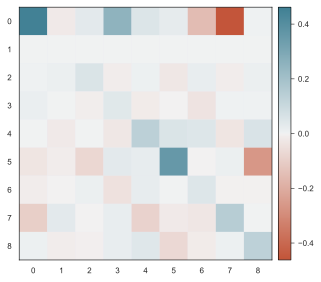

In [167]:
plot_tensor(j[4][4]);

In [168]:
torch.eig(j[1][1])[0]

tensor([[ 6.9172e-01,  0.0000e+00],
        [ 4.6056e-01,  0.0000e+00],
        [ 1.6796e-01,  0.0000e+00],
        [ 1.2712e-01,  0.0000e+00],
        [ 6.0134e-02,  0.0000e+00],
        [ 2.6384e-03,  2.1524e-03],
        [ 2.6384e-03, -2.1524e-03],
        [-4.4089e-04,  0.0000e+00],
        [-8.3797e-09,  0.0000e+00]])

In [145]:
len(j), len(j[0]), len(j[0][0]), len(j[0][0][0])

(8, 8, 9, 9)

In [133]:
len(j), len(j[0]), len(j[0][0]), len(j[0][0][0]), len(j[0][0][0][0])

(8, 8, 1, 9, 9)

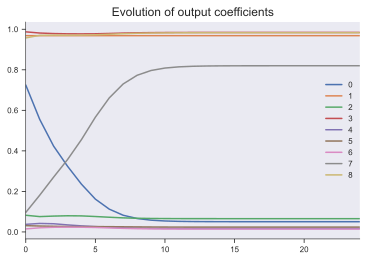

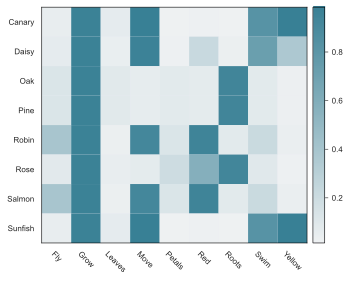

In [54]:
from _work.src.modules.replay import recirculate

chain = recirculate(model, dataloader, mean=0, sd=1, steps=25, runs=1)
d = np.array(chain['Canary'])

for i in range(len(d[0])):
    plt.plot(d[:, i], label=i)
plt.legend();
plt.title("Evolution of output coefficients");

epoch = -1
data = { k: v[epoch] for k, v in chain.items() }
plot_tensor(pd.DataFrame(data, index=dataloader.dataset.df.columns).transpose());

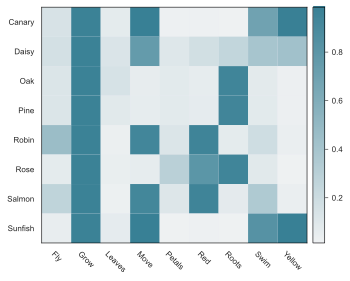

In [55]:
finals = { k: np.mean(v, axis=0) for k, v in chain.items() }
# finals = { k: v[-1] for k, v in chain.items() }
plot_tensor(pd.DataFrame(finals, index=dataloader.dataset.df.columns).transpose());

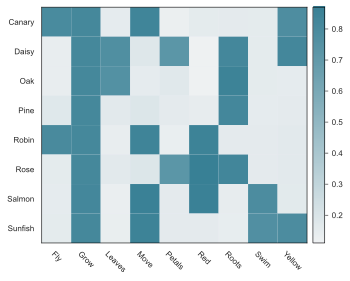

In [52]:
model.eval()
outs = []
with torch.no_grad():
    for b in dataloader.dataset:
        out = model(b['y'])
        outs.append(out.squeeze().tolist())
plot_tensor(pd.DataFrame(outs, index=dataloader.dataset.df.index, columns=dataloader.dataset.df.columns));


In [141]:
from scipy.stats import norm

In [151]:
model.eval()
outputs = []
for _ in range(1000):
    noise = torch.randn(NUM_ATTRIBUTES)
    out = model(noise)
    outputs.append(out.squeeze().tolist())

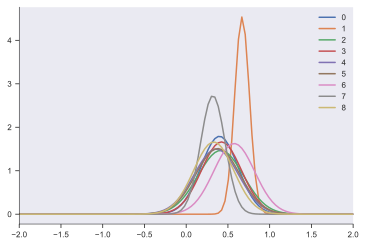

In [152]:
means = np.mean(outputs, axis=0)
stds = np.std(outputs, axis=0)

x = np.linspace(-2, 2, num=100)
for i, (m, s) in enumerate(zip(means, stds)):
    distr = norm(m, s)
    plt.plot(x, distr.pdf(x), label=i)
plt.legend();

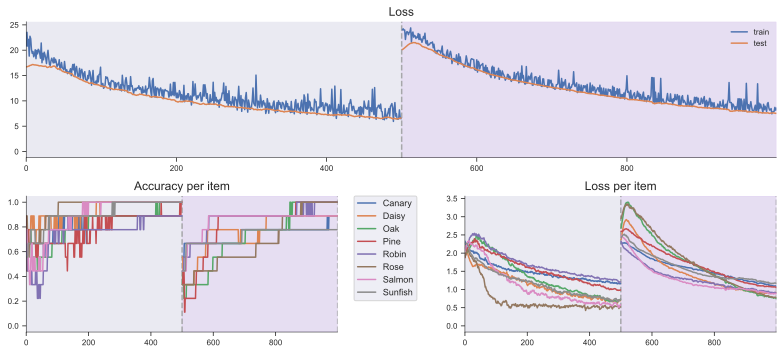

In [21]:
metrics = train_model(
    model := AutoEncoder(
        sizes=[NUM_ATTRIBUTES, HIDDEN_SIZE],
        dropout=0.05,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-3),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1000,
    l1_lambda=0.005,
    replay_interval=500,
    replay_duration=500,
    replay_strategy="conditional",
    reset=True,
)

plot_metrics(metrics);

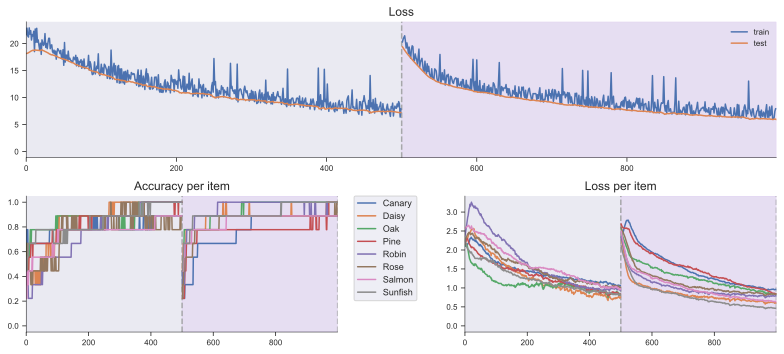

In [22]:
metrics = train_model(
    model := AutoEncoder(
        sizes=[NUM_ATTRIBUTES, HIDDEN_SIZE],
        dropout=0.05,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-3),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1000,
    l1_lambda=0.005,
    replay_interval=500,
    replay_duration=500,
    replay_strategy="baseline",
    reset=True,
)

plot_metrics(metrics);

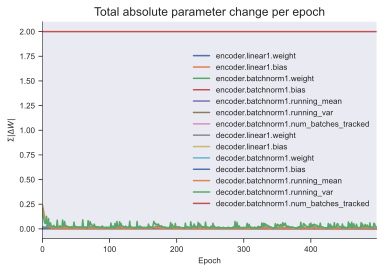

In [5]:
plot_parameters(metrics[1]);

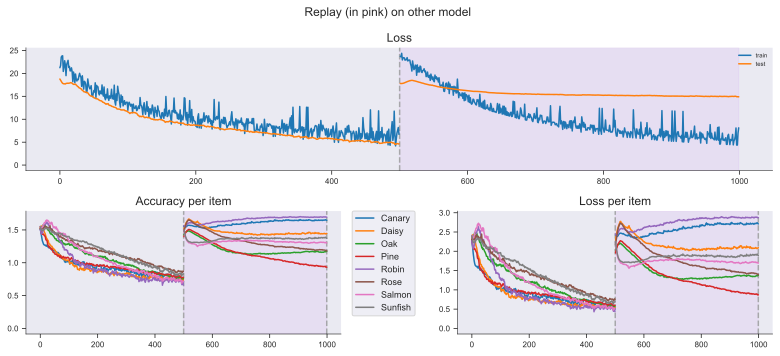

In [11]:
# plot_metrics(metrics);
# plt.gcf().suptitle("Replay (in pink) on other model");
# plt.tight_layout()
# plt.savefig("../plots/replay_other")

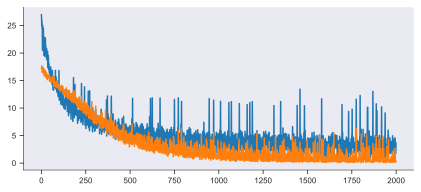

In [60]:
from torch import nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(NUM_ATTRIBUTES, HIDDEN_SIZE),
            nn.BatchNorm1d(HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(p=0.05),
        )

        self.decoder = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, NUM_ATTRIBUTES),
            nn.BatchNorm1d(NUM_ATTRIBUTES),
            nn.Sigmoid(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, NUM_ITEMS),
            # nn.LogSoftmax(dim=1),
        )
    
    def forward(self, y):
        y_encoded = self.encoder(y)
        y_pred = self.decoder(y_encoded)
        return y_pred, self.classifier(y_encoded)

    def recon_loss(self, y_pred, y):
        return nn.MSELoss(reduction="sum")(y_pred, y)
    
    def class_loss(self, y_encoded, x):
        return nn.CrossEntropyLoss(reduction="sum")(y_encoded, x)
    
    def loss_function(self, y, y_pred, x, y_encoded):
        recon_loss = nn.MSELoss(reduction="sum")(y_pred, y)
        class_loss = nn.CrossEntropyLoss(reduction="sum")(y_encoded, x)
        return recon_loss + class_loss

model = Model()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.train()

losses, recon_losses, class_losses = [], [], []
for _ in range(2000):
    train_loss = 0
    _recon_loss = 0
    _class_loss = 0
    
    for batch in dataloader:
        y = batch['y']
        x = batch['x'].argmax(dim=1)
        y_pred, y_encoded = model(y)
        
        recon_loss = model.recon_loss(y_pred, y)
        class_loss = model.class_loss(y_encoded, x)
        loss = recon_loss + class_loss
        # loss = model.loss_function(y, y_pred, x, y_encoded)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _recon_loss += recon_loss.item()
        _class_loss += class_loss.item()
    
    losses.append(train_loss)
    recon_losses.append(_recon_loss)
    class_losses.append(_class_loss)
    

plt.plot(recon_losses);
plt.plot(class_losses);

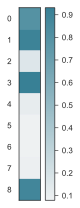

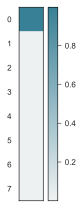

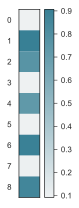

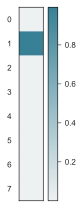

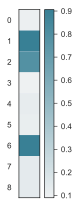

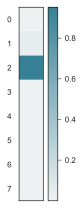

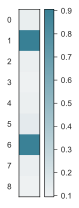

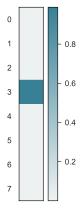

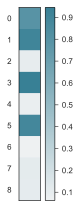

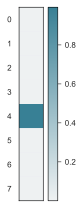

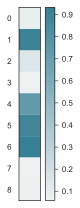

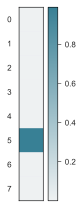

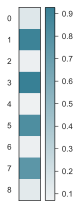

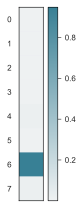

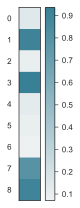

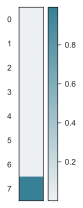

In [65]:
model.eval()
with torch.no_grad():
    for batch in dataloader.dataset:
        y = batch['y'].unsqueeze(dim=0)
        x = batch['x'].unsqueeze(dim=0).argmax(dim=1)
        y_pred, y_encoded = model(y)

        plot_tensor(y_pred)
        plot_tensor(nn.Softmax(dim=1)(y_encoded))

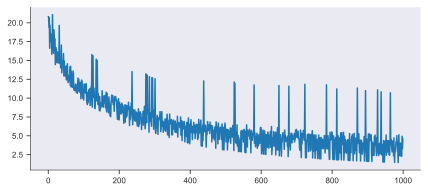

In [39]:
plt.plot(losses);

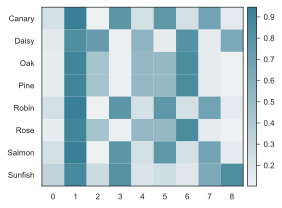

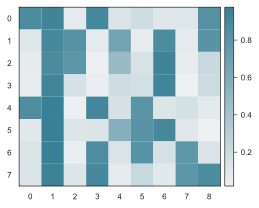

In [ ]:
from collections import defaultdict

model.eval()

patterns = defaultdict(lambda: [])
with torch.no_grad():
    for i, item in enumerate(dataloader.dataset):
        label = next(x['class'] for x in dataloader.dataset.class_map if x['index'] == i)
        y = item['y']

        for _ in range(50):
            y_pred = model(y)
            patterns[label].append(y_pred)
            y = y_pred

attractors = { k: torch.vstack(v[-10:]).mean(axis=0) for k, v in patterns.items() }
plot_tensor(pd.DataFrame(np.stack(list(attractors.values())), index=patterns.keys()));

firsts = { k: v[0] for k, v in patterns.items() }
plot_tensor(torch.vstack(list(firsts.values())));

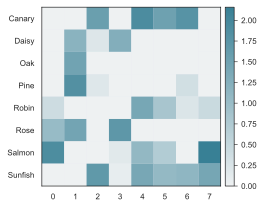

In [114]:
from _work.src.data.dataloader import create_replay_dataloader

replay_dataloader = create_replay_dataloader(
    1 * len(outputs.index.unique()),
    dataloader,
    outputs[outputs['epoch'] > 100],
    'encoder.relu1',
    strategy='conditional',
)

plot_tensor(replay_dataloader.dataset.df);
# replay_dataloader.dataset.data

training model: 100%|██████████| 500/500 [00:04<00:00, 110.54epochs/s, accuracy=0.971, loss=3.48]


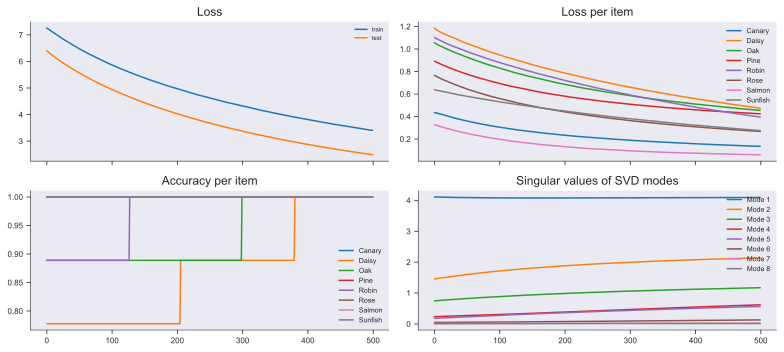

In [115]:
losses, (metrics, parameters, inputs, outputs) = train_model(
    model,
    optimizer,
    loss_fn,
    replay_dataloader,
    test_loader=dataloader,
    epochs=500,
    l1_lambda=0.005,
    reset=False,
    mode="replay",
)

plot_metrics(losses, metrics, dataloader);

In [116]:
metrics

,Fly,Grow,Leaves,Move,Petals,Red,Roots,Swim,Yellow,accuracy,loss,epoch
Canary,0.621963,0.924951,0.148388,0.864684,0.074336,0.184898,0.169254,0.339640,0.748444,1.000000,0.435870,0
Daisy,0.177383,0.870141,0.411283,0.165147,0.630490,0.348738,0.683303,0.309533,0.443627,0.777778,1.186004,0
Oak,0.240810,0.846591,0.444137,0.221572,0.442141,0.388757,0.729032,0.277615,0.344141,0.888889,1.055149,0
Pine,0.258620,0.864138,0.414341,0.237756,0.393876,0.341147,0.704040,0.272591,0.380179,1.000000,0.891503,0
Robin,0.449611,0.901917,0.177337,0.786134,0.142198,0.539486,0.258286,0.432947,0.475438,0.888889,1.102225,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Pine,0.110208,0.948300,0.459845,0.105566,0.256027,0.151266,0.874802,0.107323,0.266293,1.000000,0.423956,499
Robin,0.654785,0.964545,0.047957,0.923783,0.046524,0.720130,0.090978,0.300834,0.295739,1.000000,0.395270,499
Rose,0.036883,0.970263,0.295785,0.063068,0.828231,0.713063,0.899052,0.107321,0.201735,1.000000,0.267954,499
Salmon,0.142428,0.977392,0.021839,0.962836,0.060252,0.962330,0.051377,0.840687,0.066479,1.000000,0.060144,499


In [121]:
test_model(model, loss_fn, dataloader)

,Fly,Grow,Leaves,Move,Petals,Red,Roots,Swim,Yellow,accuracy,loss
Canary,0.773268,0.978003,0.030975,0.962373,0.014798,0.100781,0.044098,0.223318,0.863724,1.0,0.135029
Daisy,0.044306,0.957835,0.525694,0.057046,0.816141,0.238911,0.905152,0.107997,0.639018,1.0,0.473812
Oak,0.106807,0.938137,0.527014,0.092734,0.313826,0.214209,0.892305,0.105854,0.198811,1.0,0.454251
Pine,0.110085,0.948365,0.459738,0.105441,0.255800,0.151108,0.874954,0.107183,0.266138,1.0,0.423483
Robin,0.655241,0.964591,0.047851,0.923893,0.046447,0.720547,0.090844,0.300538,0.295350,1.0,0.394253
Rose,0.036841,0.970309,0.295518,0.062989,0.828470,0.713418,0.899200,0.107154,0.201689,1.0,0.267410
Salmon,0.142460,0.977426,0.021768,0.962900,0.060189,0.962461,0.051283,0.840793,0.066289,1.0,0.060058
Sunfish,0.337189,0.973535,0.049755,0.969925,0.021908,0.154416,0.038931,0.685122,0.820987,1.0,0.274811


training model: 100%|██████████| 5000/5000 [00:54<00:00, 91.23epochs/s, accuracy=0.465, loss=81]


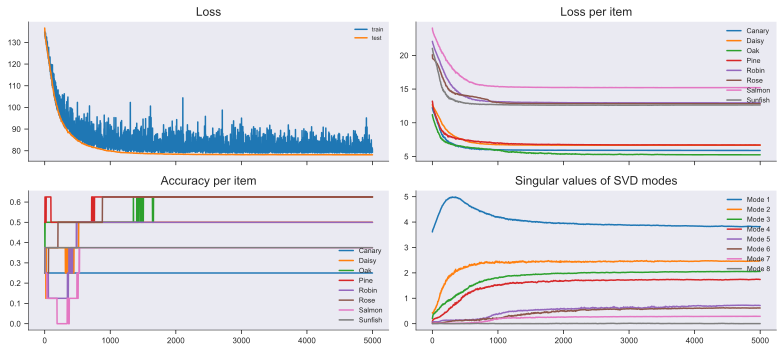

In [55]:
HIDDEN_SIZE = 8

losses, (metrics, parameters, inputs, outputs) = train_model(
    model := AutoEncoder(
        sizes=[HIDDEN_SIZE, HIDDEN_SIZE],
        dropout=0.05,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-3),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    replay_dataloader,
    epochs=1000,
    l1_lambda=0.005,
)

plot_metrics(losses, metrics, replay_dataloader);

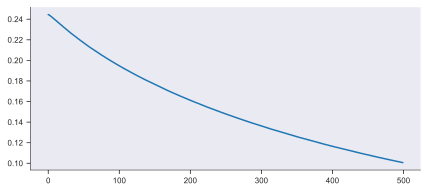

In [106]:
from _work.src.modules.train import replay_epoch

lls = []
for _ in range(500):
    loss = replay_epoch(model, optimizer, loss_fn, replay_dataloader)
    lls.append(loss)

plt.plot(lls);

training model: 100%|██████████| 4500/4500 [00:47<00:00, 95.24epochs/s, accuracy=0.242, loss=181]


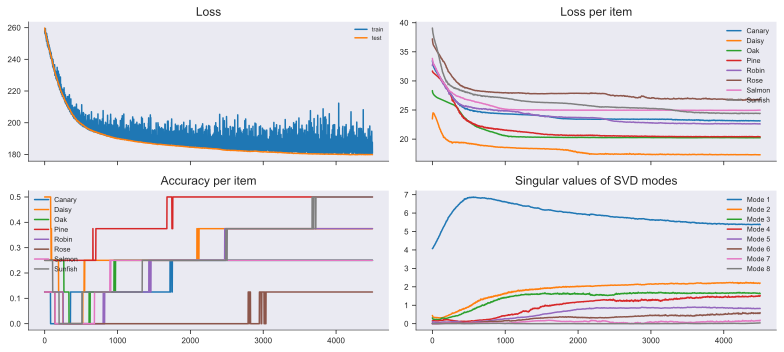

In [86]:
losses, (metrics, rparameters, rinputs, routputs) = train_model(
    model := AutoEncoder(
        sizes=[HIDDEN_SIZE, 4],
        dropout=0.05,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-3),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    replay_dataloader,
    epochs=4500,
    l1_lambda=0.005,
)

plot_metrics(losses, metrics, replay_dataloader);

In [36]:
# for b in replay_dataloader:
#     print(b)
print(replay_dataloader.batch_size)

None


In [53]:
from scipy.stats import multivariate_normal

all_data = np.array([
    [0, 1, 1, 0],
    [5, 5, 0, 1],
    [0, 0, 0, 7],
    [9, 1, 3, 2],
    [11, 2, 1, 3],
])
mean_data = np.mean(all_data, axis=0)
covariance_matrix = np.cov(all_data.transpose())
distr = multivariate_normal(mean_data, covariance_matrix)
distr.pdf([0, 1, 2, 3])

4.237087323165021e-05

(array([ 2.,  6.,  6., 17., 21., 13., 17., 11.,  6.,  1.]),
 array([-0.91534576, -0.53305565, -0.15076555,  0.23152455,  0.61381466,
         0.99610476,  1.37839486,  1.76068497,  2.14297507,  2.52526517,
         2.90755527]),
 <BarContainer object of 10 artists>)

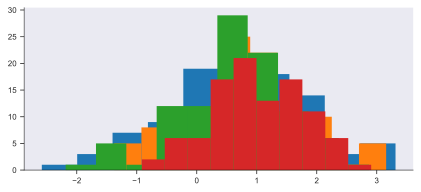

In [66]:
all_data = np.concatenate(outputs['encoder.relu1'].values)

mean_data = np.mean(all_data, axis=0)
covariance_matrix = np.cov(all_data.transpose())
distr = multivariate_normal(mean_data, covariance_matrix)

samples = distr.rvs(size=100)
plt.hist(samples[:, 0]);
plt.hist(samples[:, 1]);
plt.hist(samples[:, 2]);
plt.hist(samples[:, 3]);
# samples

(array([1872.,  258.,  316.,  786.,  980.,  615.,  986.,  910.,  639.,
         138.]),
 array([0.       , 0.2523494, 0.5046988, 0.7570482, 1.0093976, 1.261747 ,
        1.5140964, 1.7664458, 2.0187953, 2.2711446, 2.523494 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

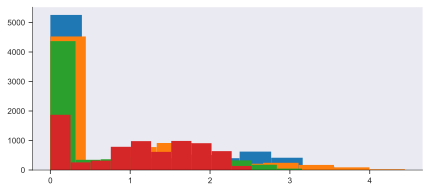

In [67]:
plt.hist(all_data[:, 0]);
plt.hist(all_data[:, 1]);
plt.hist(all_data[:, 2]);
plt.hist(all_data[:, 3]);

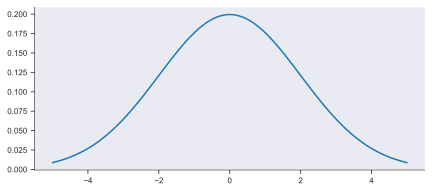

In [75]:
from scipy.stats import norm

x = np.linspace(-5, 5, num=100)
rv = norm(loc=0, scale=2)
plt.plot(x, rv.pdf(x));

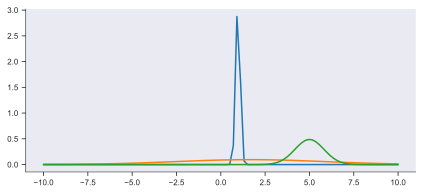

In [86]:
# all_data = np.concatenate(outputs['encoder.relu1'].values)
all_data = np.array([
    [1, 3, 5],
    [1.1, 6, 6],
    [0.8, -4, 4],
])
mean = np.mean(all_data, axis=0)
std = np.std(all_data, axis=0)

x = np.linspace(-10, 10, num=100)

for m, s in zip(mean, std):
    distr = norm(loc=m, scale=s)
    plt.plot(x, distr.pdf(x))

In [92]:
np.random.randint(5, size=10)

array([3, 4, 2, 4, 4, 4, 0, 4, 3, 0])

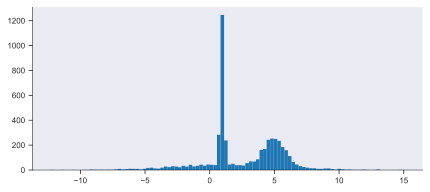

In [112]:
mix = MixtureOfGaussians(mean, std)
plt.hist(mix.rvs(size=5000), bins=100);

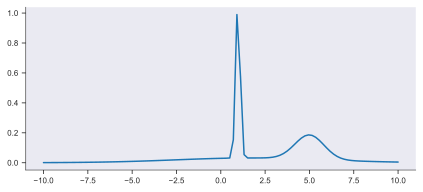

In [105]:
plt.plot(x, mix.pdf(x))